In [13]:
# import useful modules
import numpy as np
import matplotlib.pyplot as plt

داده مربوط به نقاط را به صورت آرایه ای از کتابخانه نامپای تعریف می کنیم تا سرعت محاسبات بالاتر رود. وزن ها و بایاس ها را نیز به صورت یک دیکشنری در می آوریم. هر عنصر از این دیکشنری مربوط به یک لایه است. مقدار در هر دیکشنری آرایه ای است که شامل وزن ها و بایاس ها می باشد. سطر اول هر آرایه شامل وزن های ورودی به نرون اول و بایاس آن است و سطر دوم شامل وزن های وارده به نرون دوم و بایاس آن است. بنابراین در هنگام انجام ضرب داخلی ماتریس وزن ها باید ترنسپوز شود

In [14]:
# build dataset
inputs = np.array([[1, 0],
                  [-1, 0],
                  [0, 1],
                  [0, -1],
                  [2, 0],
                  [-2, 0],
                  [0, 2],
                  [0, -2] ])
actual_outputs = np.array([1, 1, 1, 1, 0, 0, 0, 0])
# initializing weights including biases
weights = {1: np.array([[ 1,  0.5,  0],
       [ -0.25, -1,  0]]), 2: np.array([[2,  -1.5,  0],
       [0.25,  1,  0 ]]), 3: np.array([[ -1,  0.5, 0],
       [0, 0,  0]])}

we need some functions that represent activation functions and their derivatives, forward and backpropagation processes, calculating loss and cost function, training the model, predicting for an input and also a function for plotting the boundaries.

In [15]:
# Define the activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def tanh(x) :
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
# Define the derivative of the activation functions
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))
def tanh_derivative(x):
    return 1 - (tanh(x))**2

توضیحات هر تابع به طور کامل داخل تعریف تابع و یا به شکل کامنت آورده شده است

In [16]:
def forward_prop(X, Weights):
    """
    Takes input training data X and weight matrices Weights, performs forward propagation,
    and returns (Z, A). The output labels are the last row in the returned matrix A.
    """
    # number of layers, including input layer
    L = len(Weights) + 1
    # number of data samples
    m = X.shape[0]
    # Dicts for storing our calculated values
    Z = {} # input to neuron
    A = {} # after implementing activation function to the Z
    # Add bias column: because we have biases as a colomn in weight matrices and
    # we should implement dot product between x and weights and biases
    X = np.append(np.ones([m, 1]), X, axis=1)
    # set first layer values to be X
    A[1] = X
    layer = A[1]
    # Iterate through each layer, applying weights,
    # the activation functions, and storing values
    for i in range(1, L): # L=4
        z = layer.dot(Weights[i].T)
        if i == 3: # sigmoid function is just for the last layer
            a = sigmoid(z)
        else:
            a = tanh(z)
        # Only add bias layer and set up next layer if there is a next layer
        if i != (len(Weights)):
            # adding biases input for the previus reson i said
            a = np.append(np.ones([m, 1]), a, axis=1)
            # out put of a neuron is the input to a neuron of the next layer
            layer = a
        # Store values
        A[i+1] = a
        Z[i+1] = z
    return Z, A

In [17]:
def predict(X, Weights):
    """
    Performs forward propagation given the input data X and the network weights in Weights.
    Returns class assignments for the input data.
    """
    # number of data sample
    m = X.shape[0]
    # number of layers
    L = len(Weights) + 1
    # at first, this a represent the inputs
    a = X
    for i in range(1, L):
        z = np.append(np.ones([m, 1]), a, axis=1)
        if i == 3: # sigmoid function is just for the last layer
            a = sigmoid(z.dot(Weights[i].T))
        else:
            a = tanh(z.dot(Weights[i].T))
        # out put of a neuron is the input to a neuron of the next layaer
        z = a
    return np.argmax(a, axis=1)

In [18]:
def calculate_cost(X, y, Weights):
    """
    Function to calculate the cost function of a neural network for given
    training data X and network weight parameters Weights.
    """
    # number of data samples
    m = X.shape[0]
    # number of labels
    n_labels = np.unique(y).shape[0]
    # Perform forward propagation
    Z, A = forward_prop(X, Weights)
    # model outputs
    y_pred = A[len(Weights) + 1]
    # actual outputs
    y_act = np.eye(n_labels)[y,:]
    # Calculate cost in SGD method
    J = (1 / m) * np.power((y_act-y_pred), 2).sum()

    return J

In [19]:
def backpropagation(X, y, A, Z, Weights):
    """
    Performs backpropagation given the training data, results
    from forward propagation, and weights. Regulariation is optional
    and omitted by default.
    """
    # Set some useful variables
    # number of layaers, including input layer
    L = len(Weights) + 1
    # number of labels
    n_labels = len(np.unique(y))
    # number of data samples
    m = X.shape[0]
    # Transform labels into an array where each class
    # is either a 0 or 1 in an m by 2 array
    y_mat = np.eye(n_labels)[y,:]
    # This variable is where we'll store our "error" values
    er = {}
    # Set the error of the last layer by comparing
    # previously calculated predictions with the actual labels
    er[L] = A[L] - y_mat
    Deltas = {} # Our error accumulator variable
    Weight_grads = {} # The final partial derivative terms
    # Step backwards through the network
    for i in range(1, L):
        if L - i > 1: # Calculate error for all but the first layer
            if L - i == 3: # sigmoid function is just for the last layer
                er[L-i] = er[L-i+1].dot(Weights[L-i][:,1:]) * sigmoid_derivative(Z[L-i])
            else:
                er[L-i] = er[L-i+1].dot(Weights[L-i][:,1:]) * tanh_derivative(Z[L-i])
        # Accumulate error terms
        Deltas[L-i] = er[L-i+1].T.dot(A[L-i])
        # Assemble the final partial derivatives
        Weight_grads[L-i] = (1 / m) * Deltas[L-i]
    return Weight_grads

In [20]:
def plot_decision_boundary(X, y, Weights, steps=1000, cmap='RdBu'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    # Make predictions across region of interest
    labels = predict(np.c_[xx.ravel(), yy.ravel()], Weights)
    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap)
    # Get predicted labels on training data and plot
    train_labels = predict(X, Weights)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
    return fig, ax

In [21]:
def train_network(X_train, y_train, Initial_weights, lr=0.001, epochs=1000):
    """
    This function trains our network defined by the weight parameters Initial_weights.
    """
    # number of data samples
    m = X_train.shape[0]
    costs = np.zeros(epochs)
    Weights = Initial_weights.copy()
    # training process and updating the weights and biases
    for n in range(epochs):
        Z, A = forward_prop(X_train, Weights)
        # calculating cost and storing it for plotting
        cost = calculate_cost(X_train, y_train, Weights)
        costs[n] = cost
        Theta_grads = backpropagation(X_train, y_train, A, Z, Weights)
        # updating the weights
        for i in range(1, len(Weights) + 1):
            Weights[i] = Weights[i] - lr * Theta_grads[i]
        # printing the weights matrice after first epoch
        if n == 1:
            print('weights matrice after first epoch is:')
            print(Weights)
        # plotting the boundaries for some epochs
        if n % 50000 == 0:
            plot_decision_boundary(X_train, y_train, Weights)
            title = 'after %d epochs' %(n);
            plt.title(title)
    return Weights, costs

# training
in the following, i train the model for 200,000 epochs. i also show the result and requests of the problem. i think this is the best result. although i increased the number of epochs, the cost and the result stood the same. so i decided not to increasing the epochs and reporting this one.

weights matrice after first epoch is:
{1: array([[ 0.99998665,  0.50001407,  0.        ],
       [-0.25      , -1.        ,  0.        ]]), 2: array([[ 2.00002752e+00, -1.49998038e+00, -1.24797372e-05],
       [ 2.50000003e-01,  1.00000000e+00, -1.24440791e-10]]), 3: array([[-9.99688564e-01,  5.00221414e-01,  1.78729507e-04],
       [-3.38286122e-09, -4.70095563e-06,  4.35798503e-05]])}
my final weights matrice is:
{1: array([[ 2.53538722,  1.61293132,  0.        ],
       [-0.98117958, -1.71870769,  0.        ]]), 2: array([[ 1.73183456, -1.93431052, -1.50887042],
       [-0.01120014,  1.95374395,  0.25921268]]), 3: array([[-0.00499295,  2.62554248, -2.19642425],
       [-0.41937171, -2.38067743,  2.45181505]])}


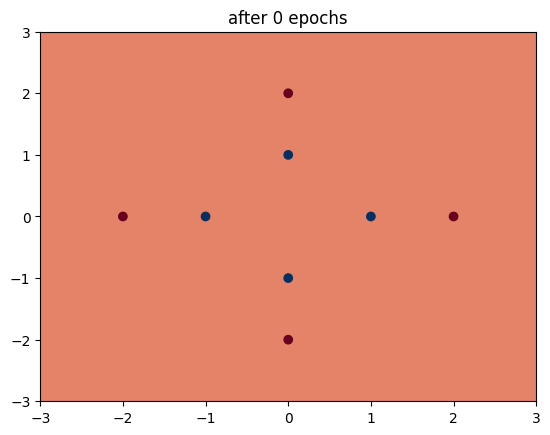

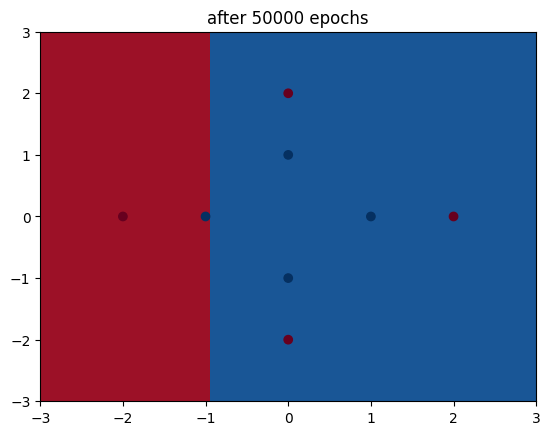

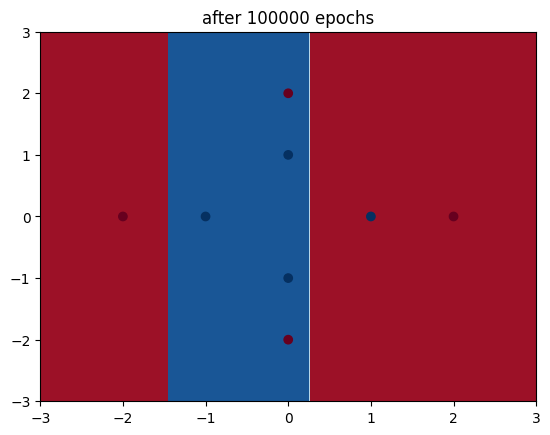

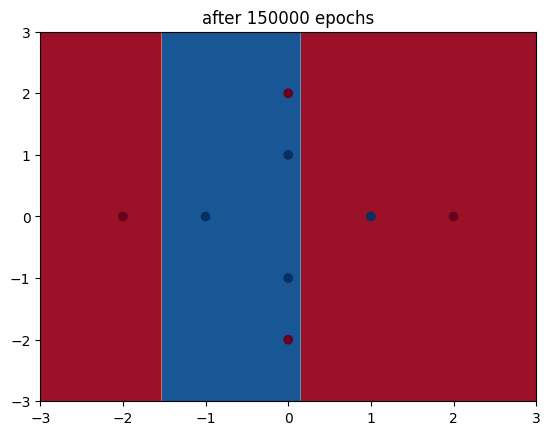

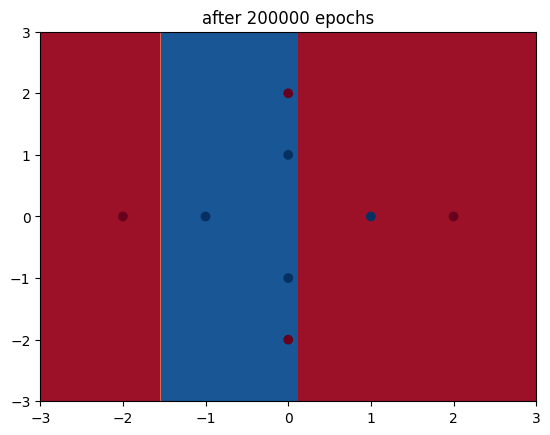

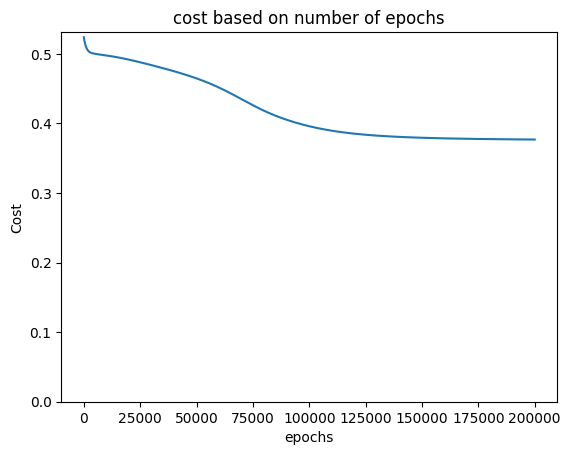

In [23]:
# train the MLP
Trained_weights, costs = train_network(inputs, actual_outputs, weights, lr=0.001, epochs=200000)
# plot the final result boundaries
plot_decision_boundary(inputs, actual_outputs, Trained_weights)
plt.title('after 200000 epochs');
# plot cost value per epoch
fig, ax = plt.subplots()
ax.plot(costs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Cost')
ax.set_xlabel('epochs')
plt.title('cost based on number of epochs');
# print final weights and biases
print('my final weights matrice is:')
print(Trained_weights)

# **سایت‌های استفاده شده**
https://jonchar.net/notebooks/Artificial-Neural-Network/#Setting-up-our-network